/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_5359/229913615.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_5359/229913615.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_5359/229913615.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Model saved.
{'Accuracy': 0.8620485849921301, 'Kappa': 0.7254820633377317, 'True Positives': 0.41914195591572534, 'True Negatives': 0.4429066290764047, 'False Positives': 0.10642426847538196, 'False Negatives': 0.031527146532487976}
                             GRECO Region  Accuracy     Kappa  True Positives  \
0         Ouest-Bretagne_et_Nord-Cotentin  0.730556  0.000000        0.000000   
1                  Massif_vosgien_central  0.748428  0.082251        0.025157   
2                        Piémont_pyrénéen  0.627551  0.124786        0.107143   
3          Côtes_et_plateaux_de_la_Manche  0.997709  0.000000        0.000000   
4                        Préalpes_du_Nord  0.876799  0.000000        0.876799   
5                           Terres_rouges  0.951488  0.888794        0.296757   
6   Châtaigneraie_du_Centre_et_de_l'Ouest  0.968439  0.043871        0.967671   
7                       Corse_occidentale  0.987309  0.008335        0.987235   
8                               Garrig

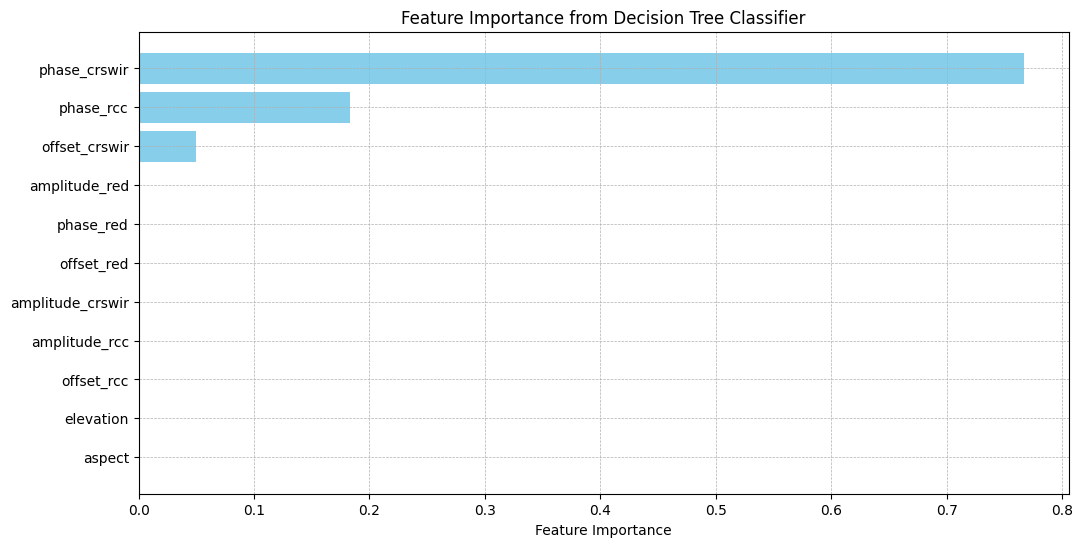

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from utils import compute_metrics
import matplotlib.pyplot as plt
import joblib 
import os

# Load the training and validation datasets
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')

# Define features and target
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X_train = train_data[features]
y_train = train_data['phen']
X_val = val_data[features]
y_val = val_data['phen']

# Replace infinity values with NaNs
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaNs with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)
X_val.fillna(X_val.mean(), inplace=True)

# Train Random Forest classifier
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5)
clf.fit(X_train, y_train)

#save model
os.makedirs('models', exist_ok=True)
joblib.dump(clf, 'models/exp3_tree_model_features-all.pkl')
print("Model saved.")

# Predict on validation set
val_data['predicted_phen'] = clf.predict(X_val)

# Compute overall metrics
metrics = compute_metrics(val_data['phen'], val_data['predicted_phen'])
print(metrics)

# Compute breakdown per GRECO region
metrics_per_greco = []

for greco_region in val_data['greco_region'].unique():
    region_data = val_data[val_data['greco_region'] == greco_region]
    y_val_region = region_data['phen']
    y_pred_region = region_data['predicted_phen']
    
    metrics = compute_metrics(y_val_region, y_pred_region)
    
    metrics_per_greco.append({
        'GRECO Region': greco_region,
        **metrics
    })

metrics_df = pd.DataFrame(metrics_per_greco)
print(metrics_df)

# Save metrics breakdown to CSV
os.makedirs('results', exist_ok=True)
metrics_df.to_csv('results/exp3_validation_metrics_per_greco_region.csv', index=False)

print("Validation metrics breakdown per GRECO region saved.")

#save per tile
metrics_per_tile = []
for tile in val_data['tile_id'].unique():
    tile_data = val_data[val_data['tile_id'] == tile]
    y_val_tile = tile_data['phen']
    y_pred_tile = tile_data['predicted_phen']
    
    metrics = compute_metrics(y_val_tile, y_pred_tile)
    
    metrics_per_tile.append({
        'Tile': tile,
        **metrics
    })

metrics_df = pd.DataFrame(metrics_per_tile)
print(metrics_df)

# Save metrics breakdown to CSV
metrics_df.to_csv('results/exp3_validation_metrics_per_tile.csv', index=False)

print("Validation metrics breakdown per tile saved.")

# Plot feature importance
feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree Classifier')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', linewidth=0.5)

# Save the feature importance plot
os.makedirs('images', exist_ok=True)
plt.savefig('images/exp3_feature_importance.png', dpi=300)
plt.show()


In [2]:
import pandas as pd
val_data = pd.read_csv('val_data.csv')
from utils import mapping_real_greco
val_data['greco_region'] = val_data['greco_region'].map(mapping_real_greco)

#load model 
clf = joblib.load('models/exp3_tree_model_features-all.pkl')

features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
directory = '/Users/arthurcalvi/Data/species/validation/tiles'

# Load the data and preprocess it
from tqdm import tqdm 
from datetime import datetime 
from utils import load_folder, calculate_slope_with_dates
import rasterio 
import os
def load_data_from_tile_inf(path: str) -> dict:
    tile_id = os.path.basename(path).split('_')[1]
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    rcc_APO = rasterio.open(os.path.join(path_features, 'rcc_APO.tif')).read()
    amplitude_map_rcc, phase_map_rcc, offset_map_rcc = rcc_APO[0], rcc_APO[1], rcc_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    features_ = {
        'amplitude_red': amplitude_map_r.ravel(),
        'phase_red': phase_map_r.ravel(),
        'offset_red': offset_map_r.ravel(),
        'amplitude_crswir': amplitude_map_crswir.ravel(),
        'phase_crswir': phase_map_crswir.ravel(),
        'offset_crswir': offset_map_crswir.ravel(),
        'amplitude_rcc': amplitude_map_rcc.ravel(),
        'phase_rcc': phase_map_rcc.ravel(),
        'offset_rcc': offset_map_rcc.ravel(),
        'elevation': elevation.ravel(),
        'aspect': aspect.ravel(),
        'tile_id': np.array([tile_id] * aspect.size)  # Add tile_id to the features
    }


    return features_, forest_mask, amplitude_map_crswir.shape 

for folder in tqdm(os.listdir(directory)):
    path = os.path.join(directory, folder)
    
    if folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
        continue
    tile_id = int(os.path.basename(path).split('_')[1])
    if tile_id not in val_data['tile_id'].unique():
        continue
    try:
        print(f"Processing {folder}")
        features_, forest_mask, shape = load_data_from_tile_inf(path)
        features_ = pd.DataFrame(features_)[features]

        #preprocess data
        features_.replace([np.inf, -np.inf], np.nan, inplace=True)
        features_.fillna(features_.mean(), inplace=True)

        results = clf.predict(features_)
        results[ forest_mask.ravel() == False ] = 0

        # Save the results to a GeoTIFF file
        ref = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif'))
        profile = ref.profile

        path_results = os.path.join(directory, folder, 'results')
        os.makedirs(path_results, exist_ok=True)
        path_file = os.path.join(path_results, f'exp3_tree_features-all.tif')
        profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=0)
        with rasterio.open(path_file, 'w', **profile) as dst:
            dst.write(results.reshape(shape), 1)

    except Exception as e:
        print(f"Error processing {folder}: {e}")
        continue


  0%|          | 0/80 [00:00<?, ?it/s]

Processing tile_0_20180101_20221231_Ouest-Bretagne_et_Nord-Cotentin_training


  4%|▍         | 3/80 [00:01<00:30,  2.52it/s]

Processing tile_25_20200102_20241230_Massif_vosgien_central_training


  5%|▌         | 4/80 [00:01<00:39,  1.91it/s]

Processing tile_71_20190102_20231231_Piémont_pyrénéen_validation


  8%|▊         | 6/80 [00:02<00:37,  1.96it/s]

Processing tile_13_20200102_20241230_Côtes_et_plateaux_de_la_Manche_validation


 10%|█         | 8/80 [00:04<00:37,  1.94it/s]

Processing tile_56_20200102_20241230_Préalpes_du_Nord_training


 11%|█▏        | 9/80 [00:05<00:47,  1.51it/s]

Processing tile_6_20200102_20241230_Ouest-Bretagne_et_Nord-Cotentin_validation


 15%|█▌        | 12/80 [00:06<00:33,  2.00it/s]

Processing tile_40_20200102_20241230_Terres_rouges_training


 20%|██        | 16/80 [00:07<00:23,  2.73it/s]

Processing tile_54_20200102_20241230_Châtaigneraie_du_Centre_et_de_l'Ouest_validation


 30%|███       | 24/80 [00:07<00:11,  4.71it/s]

Processing tile_83_20200102_20241230_Corse_occidentale_training


 32%|███▎      | 26/80 [00:08<00:14,  3.85it/s]

Processing tile_41_20200102_20241230_Terres_rouges_training


 39%|███▉      | 31/80 [00:10<00:12,  3.83it/s]

Processing tile_12_20200102_20241230_Côtes_et_plateaux_de_la_Manche_validation


 52%|█████▎    | 42/80 [00:11<00:06,  6.07it/s]

Processing tile_65_20200102_20241230_Piémont_pyrénéen_training


 65%|██████▌   | 52/80 [00:11<00:03,  7.56it/s]

Processing tile_2_20200102_20241230_Ouest-Bretagne_et_Nord-Cotentin_training


 66%|██████▋   | 53/80 [00:12<00:04,  5.79it/s]

Processing tile_79_20200102_20241230_Garrigues_validation


 75%|███████▌  | 60/80 [00:14<00:03,  5.80it/s]

Processing tile_17_20200102_20241230_Ardenne_primaire_training


 80%|████████  | 64/80 [00:15<00:03,  5.20it/s]

Processing tile_42_20200102_20241230_Terres_rouges_training


 86%|████████▋ | 69/80 [00:16<00:02,  4.73it/s]

Processing tile_80_20200102_20241230_Corse_occidentale_training


 94%|█████████▍| 75/80 [00:17<00:00,  5.17it/s]

Processing tile_18_20200102_20241230_Ardenne_primaire_training


 98%|█████████▊| 78/80 [00:18<00:00,  4.89it/s]

Processing tile_35_20200102_20241230_Premier_plateau_du_Jura_training


100%|██████████| 80/80 [00:18<00:00,  4.31it/s]
